In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pylab as plt

In [2]:
def DataLoading (mypath):
    print ("Loading the data")
    dataframe = pd.read_csv(mypath,header = None,engine = 'python',sep=",")
    return dataframe

In [3]:
def DataPreprocessing(mydataframe):
    
    # Dropping the duplicates
    recordcount = len(mydataframe)
    print ("Original number of records in the training dataset before removing duplicates is: " , recordcount)
    mydataframe.drop_duplicates(subset=None, inplace=True)  # Python command to drop duplicates
    newrecordcount = len(mydataframe)
    print ("Number of records in the training dataset after removing the duplicates is :", newrecordcount,"\n")

    #Dropping the labels to a different dataset which is used to train the recurrent neural network classifier
    df_X = mydataframe.drop(mydataframe.columns[41],axis=1,inplace = False)
    df_Y = mydataframe.drop(mydataframe.columns[0:41],axis=1, inplace = False)

    # Convert Categorial data to the numerical data for the efficient classification
    df_X[df_X.columns[1:4]] = df_X[df_X.columns[1:4]].stack().rank(method='dense').unstack()
    
    # Coding the normal as " 1 0" and attack as "0 1"
    df_Y[df_Y[41]!='normal.'] = 0
    df_Y[df_Y[41]=='normal.'] = 1
    #print (labels[41].value_counts())
    
    #converting input data into float which is requried in the future stage of building in the network
    df_X = df_X.loc[:,df_X.columns[0:41]].astype(float)

    # Normal is "1 0" and the abnormal is "0 1"
    df_Y.columns = ["y1"]
    df_Y.loc[:,('y2')] = df_Y['y1'] ==0
    df_Y.loc[:,('y2')] = df_Y['y2'].astype(int)
    

    
    return df_X,df_Y

In [4]:
def FeatureSelection(myinputX, myinputY):

    labels = np.array(myinputY).astype(int)
    inputX = np.array(myinputX)
    
    #Random Forest Model
    model = RandomForestClassifier(random_state = 0)
    model.fit(inputX,labels)
    importances = model.feature_importances_
    
    
    #Plotting the Features agains their importance scores
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
    plt.figure(figsize = (10,5))
    plt.title("Feature importances (y-axis) vs Features IDs(x-axis)")
    plt.bar(range(inputX.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(inputX.shape[1]), indices)
    plt.xlim([-1, inputX.shape[1]])
    plt.show()
    
    # Selecting top featueres which have higher importance values = here we can find "12" features
    #as we can see in the next step
    newX = myinputX.iloc[:,model.feature_importances_.argsort()[::-1][:41]]
   # Converting the X dataframe into tensors
    myX = newX.as_matrix()
    myY = labels

   
    return myX,myY

In [5]:
print ("Laoding the IDS Data")
data_path = "C:\\Users\\MaxWu\\Documents\\GitHub\\Intrusion-Detection-System-for-IoT-networks-using-Gated-Recurrent-Neural-Networks-GRU\\FinalApp.txt"
dataframe = DataLoading(data_path)

Laoding the IDS Data
Loading the data


In [6]:
print ("Data Preprocessing of loaded IDS Data")
data_X, data_Y = DataPreprocessing(dataframe)
print(data_X.shape)

Data Preprocessing of loaded IDS Data
Original number of records in the training dataset before removing duplicates is:  382266
Number of records in the training dataset after removing the duplicates is : 90695 

(90695, 41)


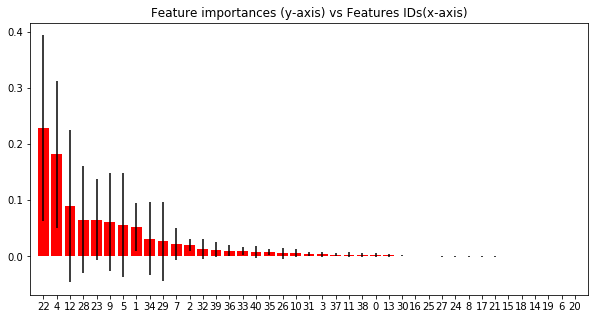

In [7]:
reduced_X,reduced_Y = FeatureSelection(data_X,data_Y)

In [8]:
train_X = reduced_X[:8000]
train_Y = reduced_Y[:8000]
print(train_X.shape)

(8000, 41)


In [9]:
test_X = reduced_X[8001:10000]
test_Y = reduced_Y[8001:10000]

In [10]:
print ("Train X shape is :", train_X.shape)
print ("Train Y shape is :", train_Y.shape)
print ("Test X shape is :", test_X.shape)
print ("Test Y shape is :", test_Y.shape)

Train X shape is : (8000, 41)
Train Y shape is : (8000, 2)
Test X shape is : (1999, 41)
Test Y shape is : (1999, 2)


In [11]:
semitrain_X = pd.DataFrame(train_X)
semitest_X = pd.DataFrame(test_X)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [13]:
scaler_traindata = scaler.fit(semitrain_X)
train_norm = scaler_traindata.transform(semitrain_X)
train_norm_X = pd.DataFrame(train_norm)

In [14]:
scaler_testdata = scaler.fit(semitest_X)
test_norm = scaler_testdata.transform(semitest_X)
test_norm_X = pd.DataFrame(test_norm)

In [15]:
#Define Hyper Parameters for the model
learning_rate = 0.001
n_classes = 2
display_step = 100
input_features = train_X.shape[1] #No of selected features(columns)
print(train_X.shape[1])
training_cycles = 1000
time_steps = 5 # No of time-steps to backpropogate
hidden_units = 3 #No of LSTM units in a LSTM Hidden Layer

41


In [16]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float64,shape = [None,time_steps,input_features], name = "x-input")
    y = tf.placeholder(tf.float64, shape = [None,n_classes],name = "y-input")
#Weights and Biases
with tf.name_scope("weights"):
    W = tf.Variable(tf.random_normal([hidden_units,n_classes]),name = "layer-weights")

with tf.name_scope("biases"):
    b = tf.Variable(tf.random_normal([n_classes]),name = "unit-biases")
    
print(W.shape)

(3, 2)


In [17]:
def rnn_data(data, time_steps, labels=False):
    """
    creates new data frame based on previous observation
      * example:
        l = [1, 2, 3, 4, 5]
        time_steps = 2
        -> labels == False [[1, 2], [2, 3], [3, 4]]
        -> labels == True [3, 4, 5]
    """
    rnn_df = []
    for i in range(len(data) - time_steps):
        if labels:
            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])

    return np.array(rnn_df, dtype=np.float32)

In [18]:
train_data_X = pd.DataFrame(train_norm_X)
train_data_Y = pd.DataFrame(train_Y)
newtrain_X = rnn_data(train_data_X,time_steps,labels = False)
newtrain_Y = rnn_data(train_data_Y,time_steps,labels = True)

In [19]:
print ("Shape of new train X",newtrain_X.shape)
print ("Shape of new train Y",newtrain_Y.shape)

Shape of new train X (7995, 5, 41)
Shape of new train Y (7995, 2)


In [20]:
test_data_X = pd.DataFrame(test_norm_X)
test_data_Y = pd.DataFrame(test_Y)
newtest_X = rnn_data(test_data_X,time_steps,labels = False)
newtest_Y = rnn_data(test_data_Y,time_steps,labels = True)

print ("Shape of new test X",newtest_X.shape)
print ("Shape of new test Y",newtest_Y.shape)

Shape of new test X (1994, 5, 41)
Shape of new test Y (1994, 2)


In [21]:
x_ = tf.unstack(x,time_steps,axis =1)

In [22]:
print(x_)

[<tf.Tensor 'unstack:0' shape=(?, 41) dtype=float64>, <tf.Tensor 'unstack:1' shape=(?, 41) dtype=float64>, <tf.Tensor 'unstack:2' shape=(?, 41) dtype=float64>, <tf.Tensor 'unstack:3' shape=(?, 41) dtype=float64>, <tf.Tensor 'unstack:4' shape=(?, 41) dtype=float64>]


In [23]:
gru_cell = tf.contrib.rnn.BasicRNNCell(hidden_units)

In [24]:
with tf.variable_scope('MyGRUCel36'):
    gruoutputs,grustates = tf.contrib.rnn.static_rnn(gru_cell,x_,dtype=tf.float64)
print(gruoutputs[-1].shape)

(?, 3)


In [25]:
output =  tf.add(tf.matmul(gruoutputs[-1],tf.cast(W,tf.float64)),tf.cast(b,tf.float64))
print(W.shape)
print(y.shape)

(3, 2)
(?, 2)


In [26]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits = output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


In [27]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [28]:
print(sess.run(output[0], feed_dict ={x :newtrain_X,y:newtrain_Y}))
print(sess.run(y[0], feed_dict ={x :newtrain_X,y:newtrain_Y}))
print(sess.run(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y), feed_dict ={x :newtrain_X,y:newtrain_Y}).shape)

[ 2.64485638 -0.71133025]
[1. 0.]
(7995,)


In [29]:
#for i in range (training_cycles):
#    sess.run([optimizer,cost], feed_dict = {x:newtrain_X, y:newtrain_Y})
#    
#    if (i) % display_step == 0:
#        print ("Cost for the training cycle : ",i," : is : ",sess.run(cost, feed_dict ={x :newtrain_X,y:newtrain_Y}))
#correct = tf.equal(tf.argmax(output, 1), tf.argmax(y,1))
#accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
#print('Accuracy on the overall test set is :',accuracy.eval({x:newtest_X, y:newtest_Y}))